# What Makes a Champion?
## DSCI 100 Group 15 Project Proposal

Arimoto, Yuhei - Student Number | 
Dufour-Nogueira, Emma Héloïse - 34570614 | 
Huang, Felix - Student Number | 
Tan Palanca, Katrina Marie (Kim) - 98857568

### Introduction

Drawing predictions based on existing data sets provides a detailed interpretation and conclusions regarding the observations within it. Regression is one way in which predictive analysis of a data set can be achieved, predicting a numerical observation. Using the data set “Game results for Top 500 Players from 2017-2019”, specifically "atp2017-2019.csv", created by Jeff Sackman is the primary data to be manipulated.

The goal of this project is to create a K-nearest neighbors (KNN) regression model that will determine the probability that a player will win a tennis game based on their skills in serving through the following predictive question:
- How likely could a professional tennis player be to win a tennis game based on their serving skill?

### Preliminary Exploratory Data Analysis

In [31]:
library(tidyverse)
library(repr)
library(tidymodels)

set.seed(1234)

#this library() function loads the tidymodels, repr, and tidyverse libraries into R
#the set.seed() function sets the seed for the project

In [32]:
data <- read_csv("atp2017-2019.csv")
#the tennnis player data is referred to as the object "data" throughout this analysis

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  .default = col_double(),
  tourney_id = col_character(),
  tourney_name = col_character(),
  surface = col_character(),
  tourney_level = col_character(),
  winner_seed = col_character(),
  winner_entry = col_character(),
  winner_name = col_character(),
  winner_hand = col_character(),
  winner_ioc = col_character(),
  loser_seed = col_character(),
  loser_entry = col_character(),
  loser_name = col_character(),
  loser_hand = col_character(),
  loser_ioc = col_character(),
  score = col_character(),
  round = col_character()
)

See spec(...) for full column specifications.



In [33]:
data <- data%>%
    select(winner_name, minutes, w_ace, w_df, w_svpt, w_SvGms, w_1stIn, w_1stWon, loser_name)%>%
#the columns relevant to our analysis are selected using this select() function
    filter(!is.na(winner_name), !is.na(minutes), !is.na(w_ace), !is.na(w_df), !is.na(w_svpt),
          !is.na(w_SvGms), !is.na(w_1stIn), !is.na(w_1stWon))
#the !is.na() argument in the filter() function eliminates NA values in the relevant columns

head(data, 5)

winner_name,minutes,w_ace,w_df,w_svpt,w_SvGms,w_1stIn,w_1stWon,loser_name
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Kei Nishikori,124,3,3,77,13,44,31,Daniil Medvedev
Daniil Medvedev,82,10,1,52,10,33,28,Jo Wilfried Tsonga
Kei Nishikori,66,2,2,47,8,33,26,Jeremy Chardy
Jo Wilfried Tsonga,106,12,2,68,11,43,34,Alex De Minaur
Daniil Medvedev,129,12,3,105,16,68,48,Milos Raonic


In [34]:
#the following code consists of tidying the data

player_data <- data%>%
    select(winner_name, loser_name)%>%
    filter(!is.na(winner_name), !is.na(loser_name))
#this code creates a dataframe containing all of the players' names in the original data (both winners and losers)
#the frequency of repetition of these names is equivalent to the number of matches that each player partook in
#(e.g. player x appears twice, he took part in 2 matches)

player_data_column <- data.frame(all_players=unlist(player_data, use.names = FALSE))
#this code creates a single column containing all of the players names

winner_names <- player_data%>%
    group_by(winner_name)%>%
    summarize(n_wins = n())%>%
    distinct()
#this code creates a table containing only the winners names as well as the number of wins of each winning player

n_games_all <- player_data_column%>%
    group_by(all_players)%>%
    summarize(n_games = n())%>%
    subset(all_players %in% winner_names$winner_name)
#this code adds a column to player_data_column containing the number of games each player partook in
#it then extracts the rows which contain player names present in winner_names

winner_data <- tibble(winner_name = winner_names$winner_name,
                      n_wins = winner_names$n_wins, 
                      n_games = n_games_all$n_games)%>%
    mutate(percentage_win = n_wins/n_games)
#this code creates a tibble containing the winners' names, their number of matches won, and the total number of matches they partook in
#the mutate() function then adds a column detailing the win ratios of each winner in relation to their total number of matches played in

data <- data%>%
    group_by(winner_name)%>%
    summarize(number_of_wins = n(),
              avg_duration = mean(minutes),
              avg_ace = mean(w_ace),
              avg_df = mean(w_df),
              avg_svpt = mean(w_svpt),
              avg_svgm = mean(w_SvGms),
              avg_first = mean(w_1stIn),
              avg_first_won = mean(w_1stWon))%>%
    bind_cols(winner_data)%>%
#combining the relevant columns in winner_data with the data dataframe
    select(winner_name...1,
           n_wins,
           n_games,
           percentage_win, 
           avg_duration, 
           avg_ace, 
           avg_df, 
           avg_svpt, 
           avg_svgm, 
           avg_first, 
           avg_first_won)%>%
#removing repeats in data by averaging all the values over three years
    rename(winner_name = winner_name...1)%>%
    mutate(total_avg_svpt = avg_svpt + avg_svgm,
           first_win_percentage_avg = (avg_first_won/avg_first)*100)%>%
#summing service points and service games (both are points earned by serving)
    select(winner_name,
           n_wins, 
           n_games, 
           percentage_win, 
           avg_duration, 
           avg_ace, 
           avg_df, 
           total_avg_svpt, 
           first_win_percentage_avg)%>%
#selecting relevant variables
    mutate(n_wins = as.double(n_wins), 
           n_games = as.double(n_games), 
           avg_duration = round(avg_duration, 2), 
           avg_ace = round(avg_ace, 2),
           avg_df = round(avg_df, 2), 
           total_avg_svpt = round(total_avg_svpt, 2), 
           first_win_percentage_avg = round(first_win_percentage_avg, 2),
           percentage_win = round(percentage_win, 2))
#converting variables to appropriate data types and rounding to 2 decimal places

head(data, 5)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

New names:
* winner_name -> winner_name...1
* winner_name -> winner_name...10



winner_name,n_wins,n_games,percentage_win,avg_duration,avg_ace,avg_df,total_avg_svpt,first_win_percentage_avg
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Adam Pavlasek,3,8,0.38,124.67,11.33,3.67,118.67,76.28
Adrian Mannarino,80,157,0.51,111.79,6.09,2.24,92.75,73.38
Adrian Menendez Maceiras,4,15,0.27,120.00,7.25,2.50,99.00,71.95
Akira Santillan,2,6,0.33,44.50,4.00,1.50,50.50,84.62
Albert Ramos,72,153,0.47,125.51,3.97,2.32,96.43,71.86


In [36]:
data_split <- initial_split(data, prop = 0.75, strata = percentage_win)
data_train <- training(data_split)
data_test <- testing(data_split)

#randomly splits 75% of the data into the training and testing sets using
#percentage_win as the strata

In [38]:
train_summmary <- data_train%>%
    tibble(number_of_players = nrow(data_train),                                                   #total number of winners in the data
           avg_match_duration = mean(avg_duration),                                                #average match duration of each winner
           avg_ace_n = mean(avg_ace),                                                              #average number of aces of each winner
           avg_df_n = mean(avg_df),                                                                #average number of double faults by each winner
           avg_total_avg_svpt = mean(total_avg_svpt),                                              #average total number of points earned by serving of each winner
           avg_first_win_percentage_avg = mean(first_win_percentage_avg),                          #average percentage of succesful first serves of each winner
           top_win_p = max(percentage_win),                                                        #highest win ratio in the data 
           bottom_win_p = min(percentage_win))%>%                                                  #lowest win ratio in the data
    select(number_of_players, 
           avg_match_duration, 
           avg_ace_n, avg_df_n, 
           avg_total_avg_svpt, 
           avg_first_win_percentage_avg, 
           top_win_p, 
           bottom_win_p)%>%
#the select() function keeps relevant columns
    slice(1)%>%
    mutate(number_of_players = as.double(number_of_players), 
           avg_match_duration = round(avg_match_duration, 2), 
           avg_ace_n = round(avg_ace_n, 2),
           avg_df_n = round(avg_df_n, 2), 
           avg_total_avg_svpt = round(avg_total_avg_svpt, 2), 
           avg_first_win_percentage_avg = round(avg_first_win_percentage_avg, 2))
#converting variables to appropriate data types and rounding to 2 decimal places

train_summmary

number_of_players,avg_match_duration,avg_ace_n,avg_df_n,avg_total_avg_svpt,avg_first_win_percentage_avg,top_win_p,bottom_win_p
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
190,112.6,6.93,2.87,96.45,74.82,0.88,0.09


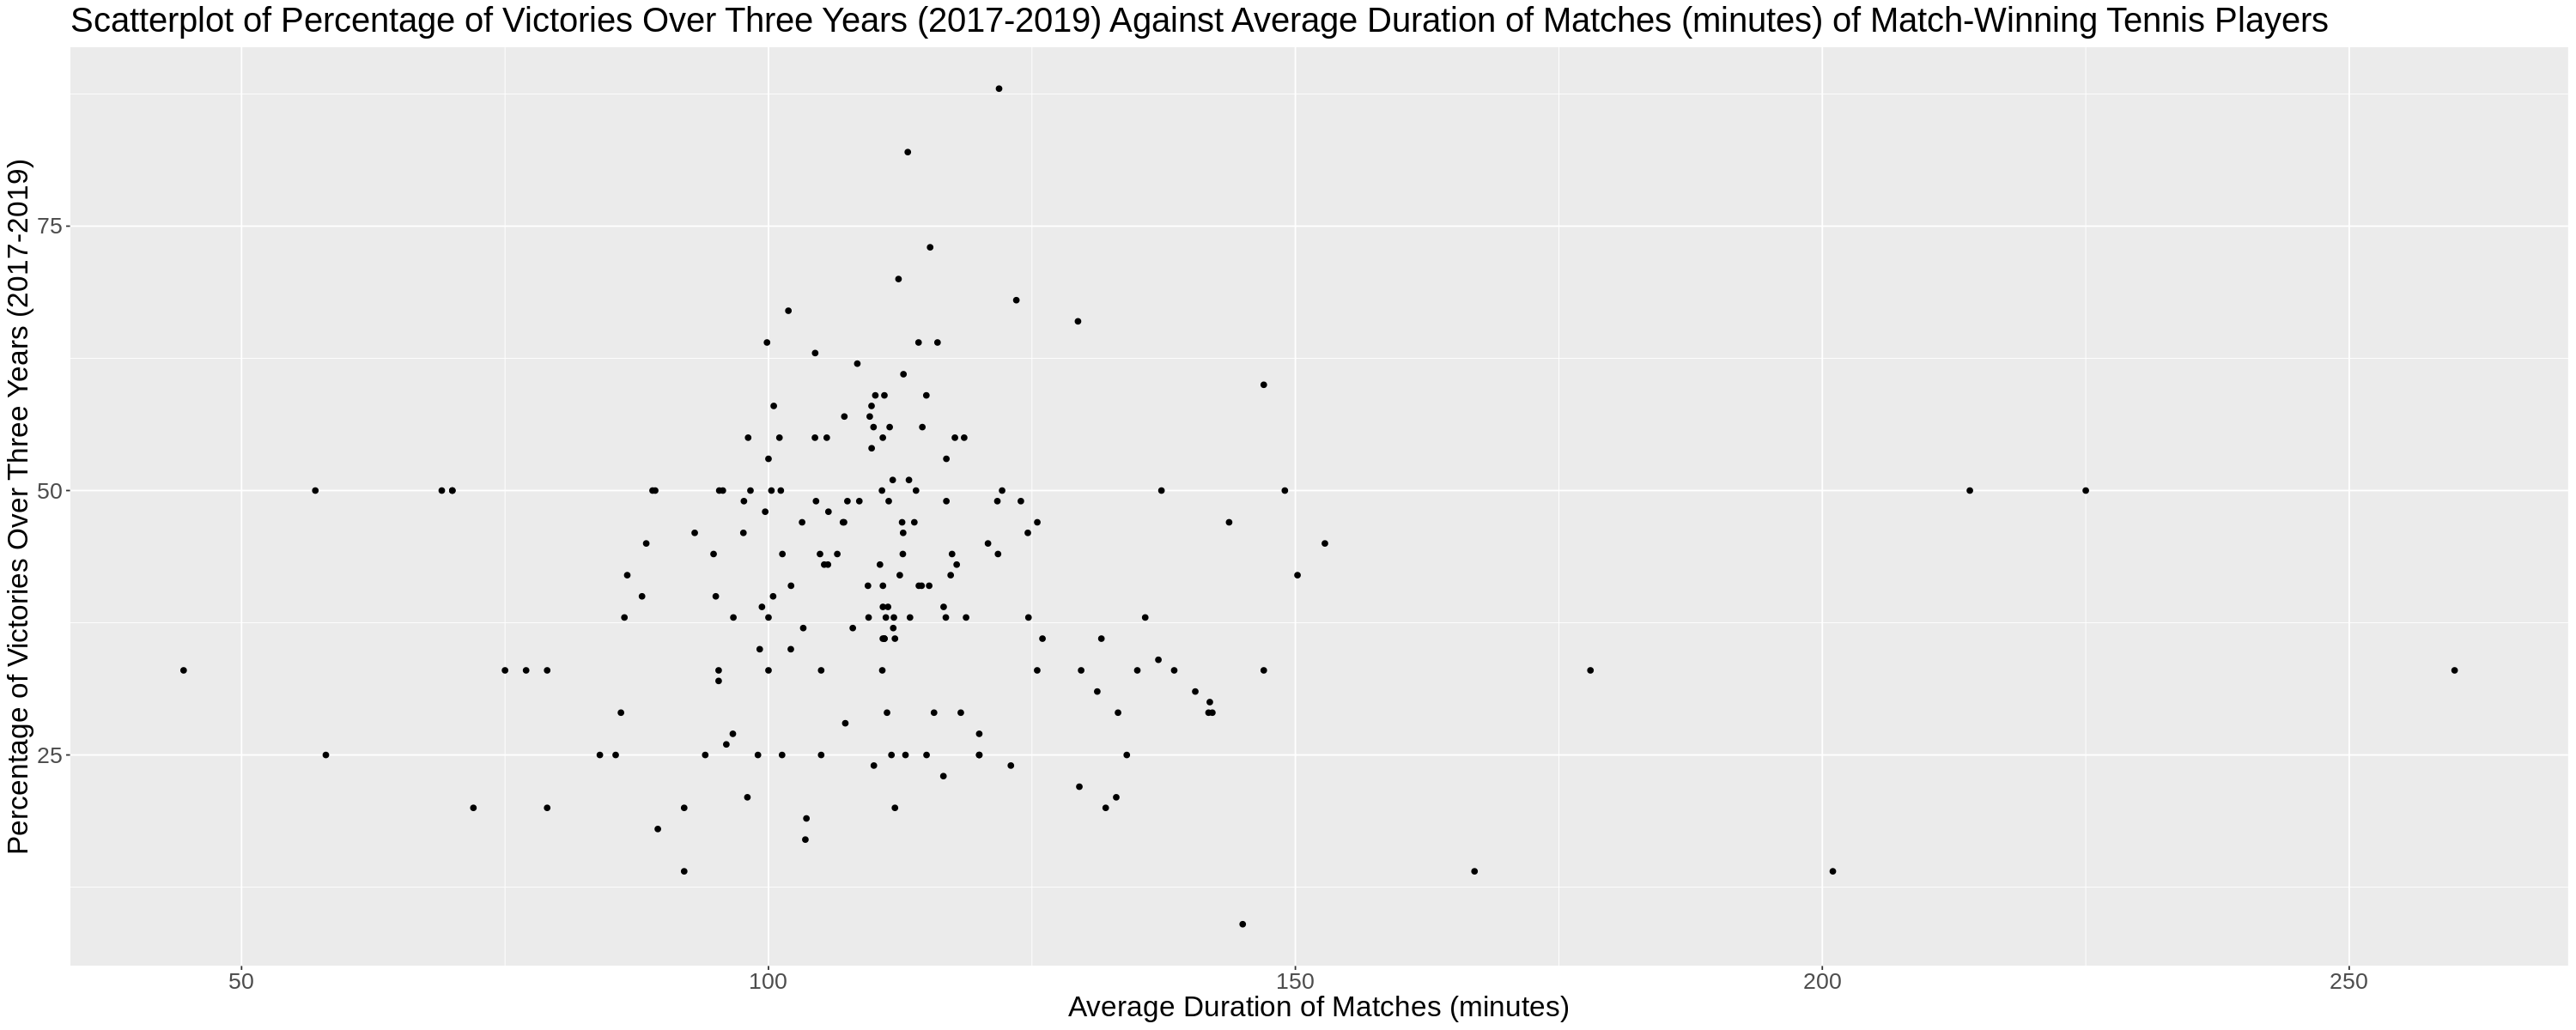

In [39]:
options(repr.plot.width = 25, repr.plot.height = 10)

duration_scatterplot <- data_train%>%
    ggplot(aes(x=avg_duration, y=percentage_win*100))+
    geom_point()+
    theme (text = element_text (size = 20))+
    labs(x="Average Duration of Matches (minutes)", y="Percentage of Victories Over Three Years (2017-2019)")+
    ggtitle("Scatterplot of Percentage of Victories Over Three Years (2017-2019) Against Average Duration of Matches (minutes) of Match-Winning Tennis Players")
duration_scatterplot

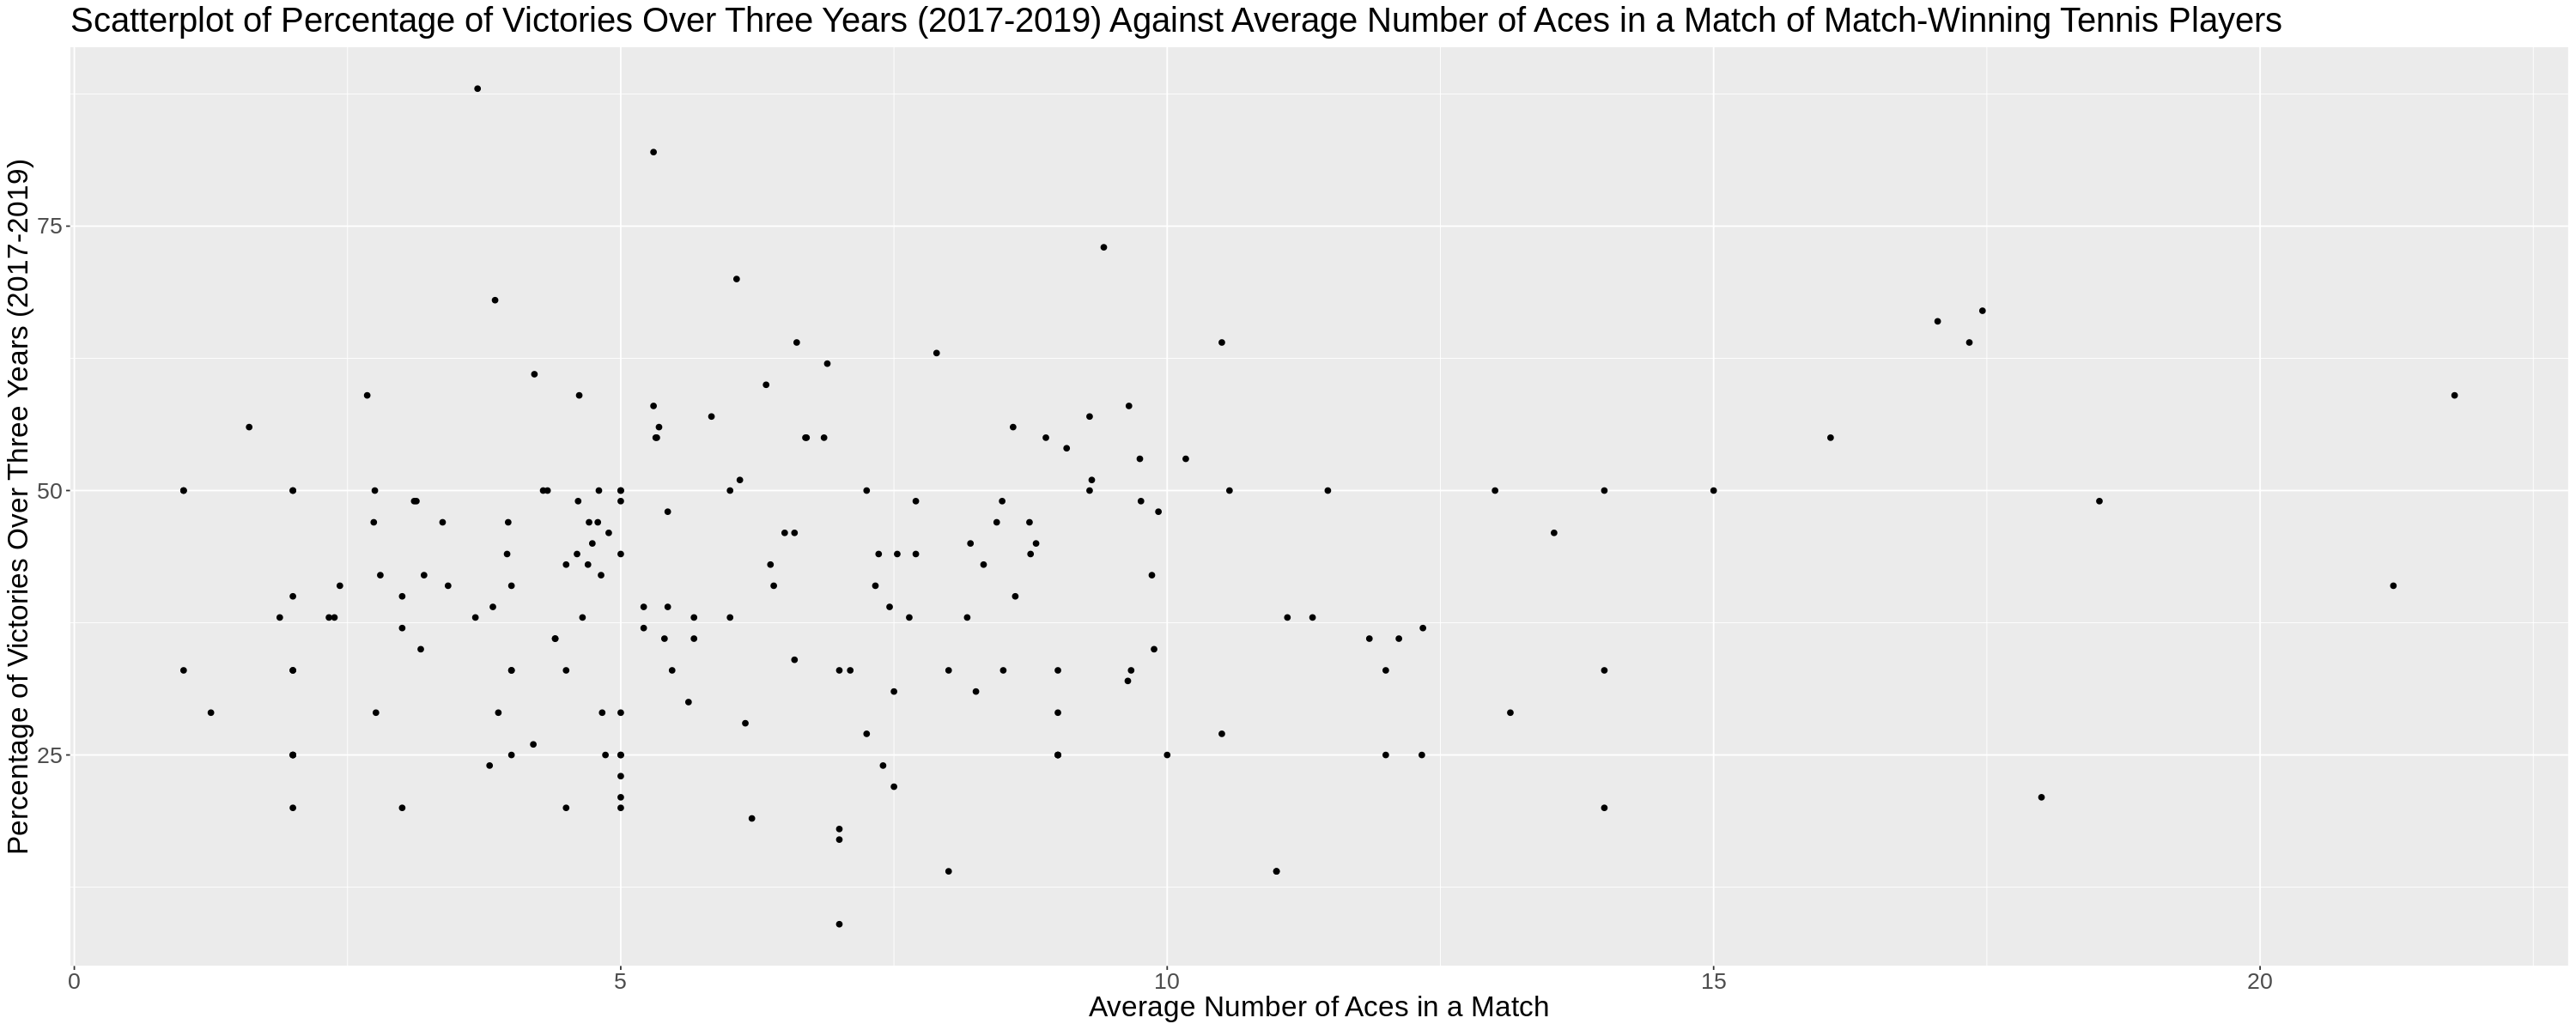

In [40]:
options(repr.plot.width = 25, repr.plot.height = 10)

ace_scatterplot <- data_train%>%
    ggplot(aes(x=avg_ace, y=percentage_win*100))+
    geom_point()+
    theme (text = element_text (size = 20))+
    labs(x="Average Number of Aces in a Match", y="Percentage of Victories Over Three Years (2017-2019)")+
    ggtitle("Scatterplot of Percentage of Victories Over Three Years (2017-2019) Against Average Number of Aces in a Match of Match-Winning Tennis Players")
ace_scatterplot

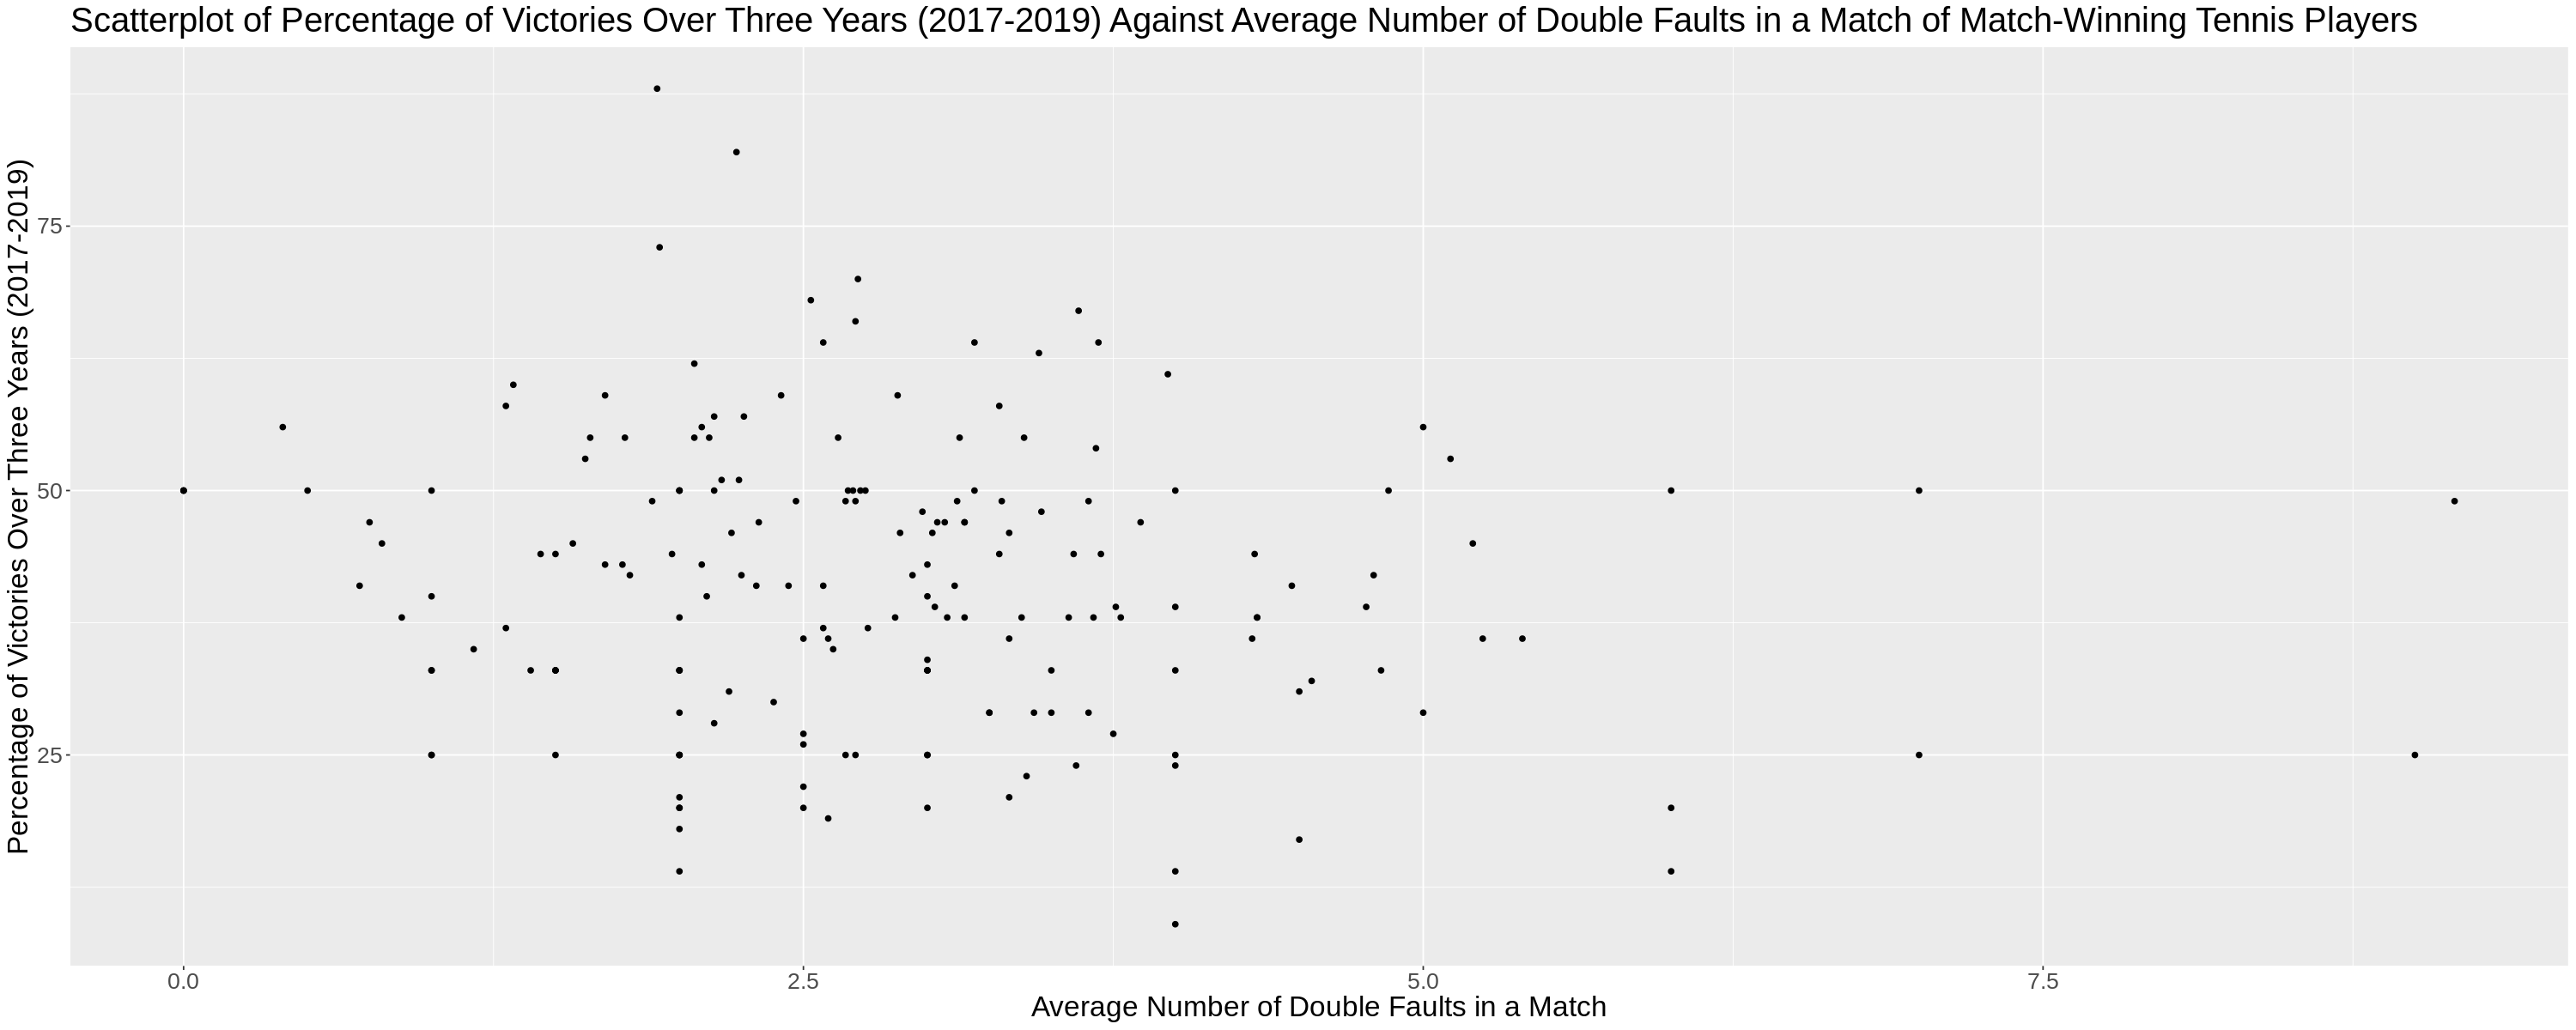

In [41]:
options(repr.plot.width = 25, repr.plot.height = 10)

df_scatterplot <- data_train%>%
    ggplot(aes(x=avg_df, y=percentage_win*100))+
    geom_point()+
    theme (text = element_text (size = 20))+
    labs(x="Average Number of Double Faults in a Match", y="Percentage of Victories Over Three Years (2017-2019)")+
    ggtitle("Scatterplot of Percentage of Victories Over Three Years (2017-2019) Against Average Number of Double Faults in a Match of Match-Winning Tennis Players")
df_scatterplot

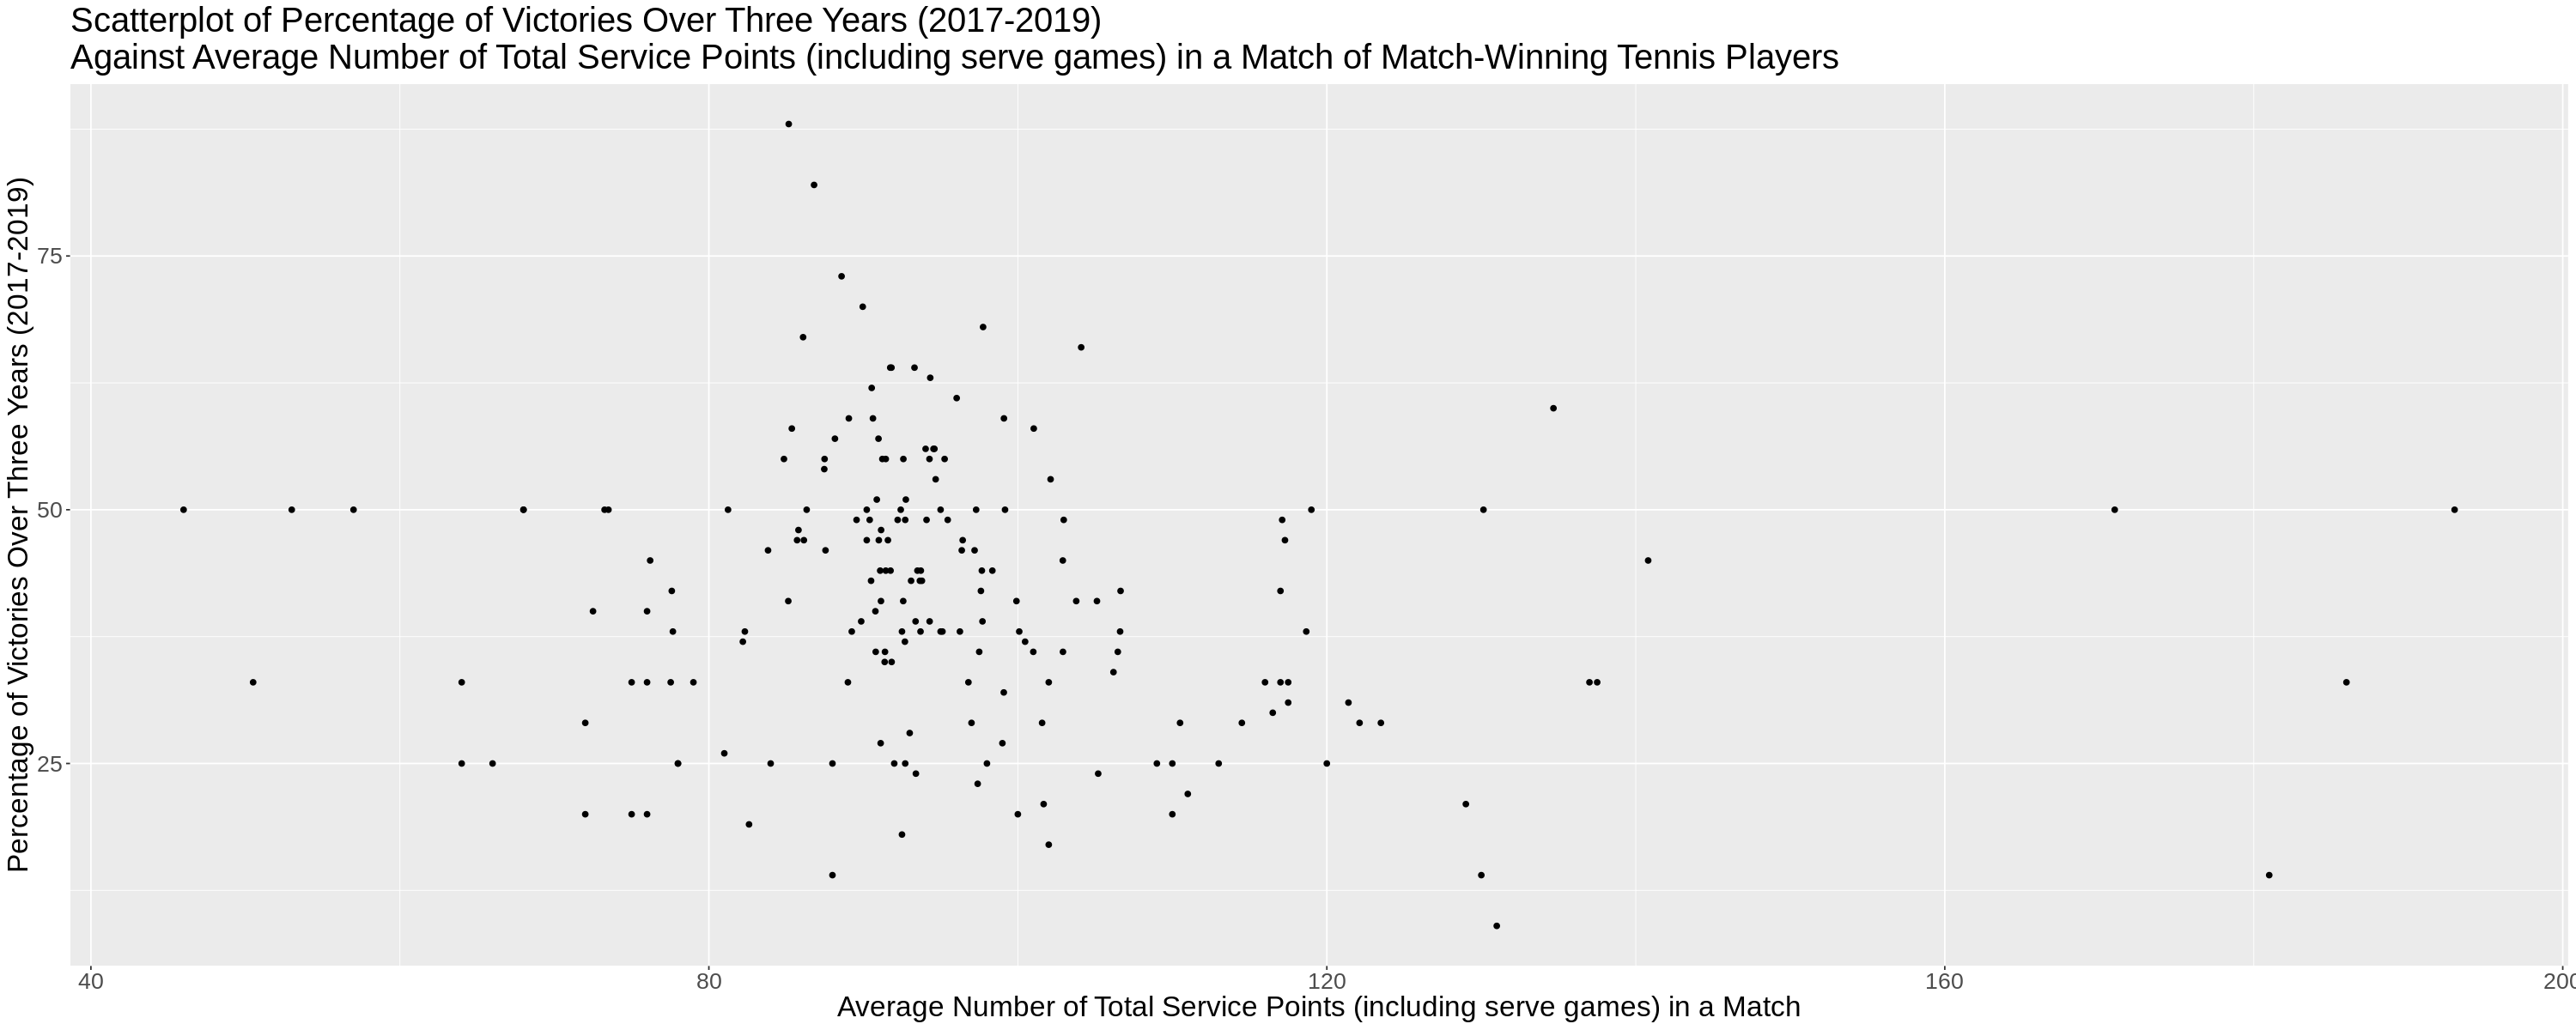

In [42]:
options(repr.plot.width = 25, repr.plot.height = 10)

svpt_scatterplot <- data_train%>%
    ggplot(aes(x=total_avg_svpt, y=percentage_win*100))+
    geom_point()+
    theme (text = element_text (size = 20))+
    labs(x="Average Number of Total Service Points (including serve games) in a Match", y="Percentage of Victories Over Three Years (2017-2019)")+
    ggtitle("Scatterplot of Percentage of Victories Over Three Years (2017-2019)\nAgainst Average Number of Total Service Points (including serve games) in a Match of Match-Winning Tennis Players")
svpt_scatterplot

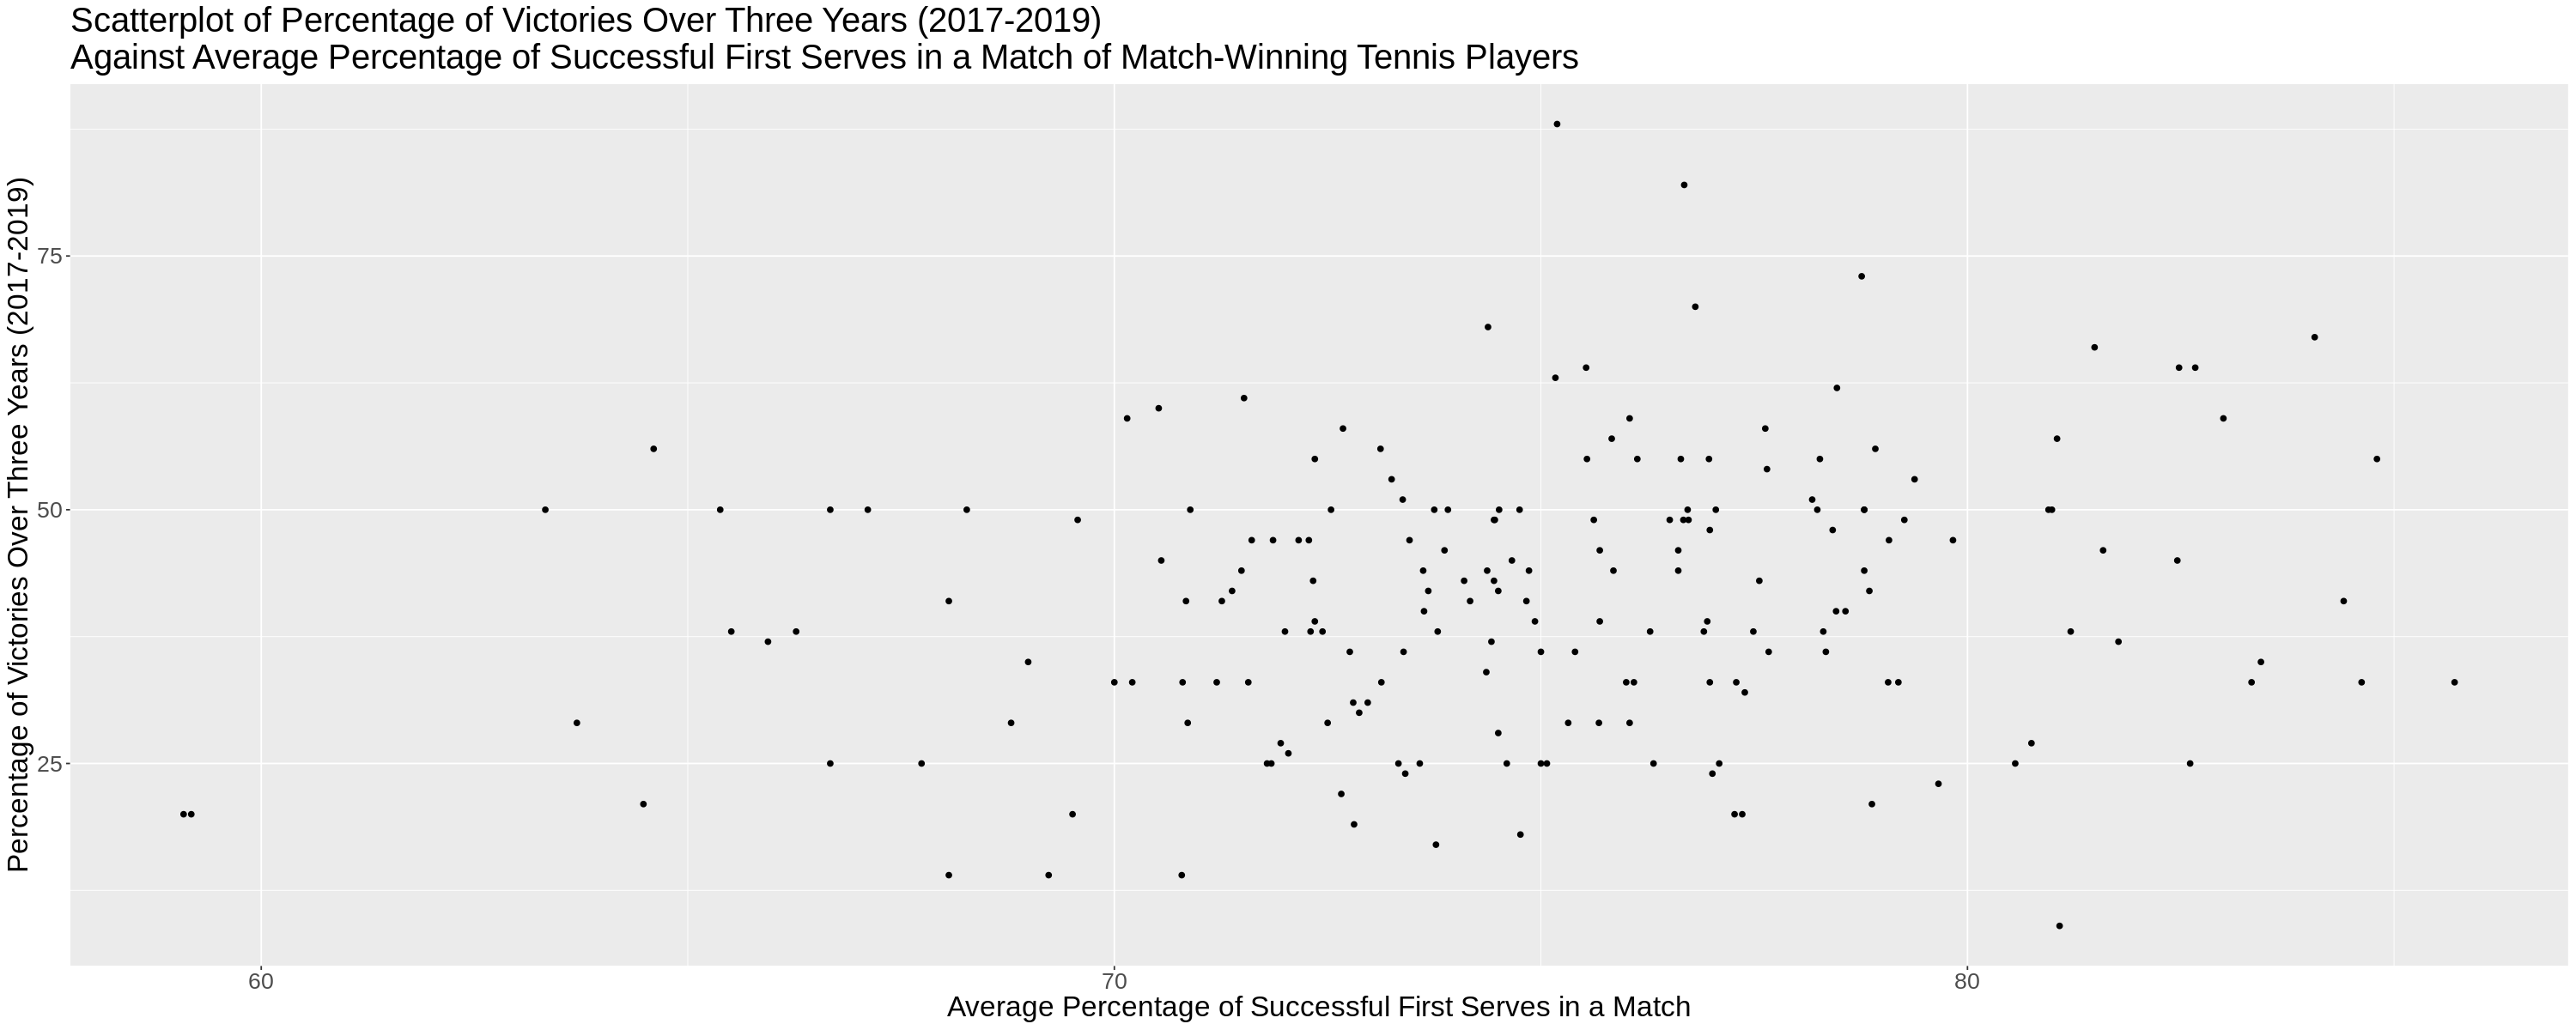

In [43]:
options(repr.plot.width = 25, repr.plot.height = 10)

first_scatterplot <- data_train%>%
    ggplot(aes(x=first_win_percentage_avg, y=percentage_win*100))+
    geom_point()+
    theme (text = element_text (size = 20))+
    labs(x="Average Percentage of Successful First Serves in a Match", y="Percentage of Victories Over Three Years (2017-2019)")+
    ggtitle("Scatterplot of Percentage of Victories Over Three Years (2017-2019)\nAgainst Average Percentage of Successful First Serves in a Match of Match-Winning Tennis Players")
first_scatterplot

### Methods

### Expected Outcomes

The data analysis on "Game results for Top 500 Players from 2017-2019" is expected to predict the percentage of games a player will win based comprehensively on the variables that indicate a player's serving skills. For example, a player with high avg_df — the average number of double faults — should intuitively have a lower win ratio than one with a low avg_df.

The results of the data analysis could help companies/sponsors find good players — that is, likely to win games — by assessing their serving skill. It could also provide guidance as to how tennis players should train to maximize their number of victorious matches.

The analysis could lead to future questions. This includes what can be done to improve the model or accuracy of the predictions, and if the accuracy of the model is low, it would lead to further investigation on what causes the inaccuracy.